In [221]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [222]:
data = pd.read_csv('labelled_dataset.csv',index_col=0)
data = data[['labels','body','parent']]
data.head(2)

,labels,body,parent
0,supporting,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...
1,supporting,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...


## Checking Label Distribution and Assigning Weights

In [223]:
data.labels.value_counts()

commenting     614
supporting     299
denying        137
questioning    105
Name: labels, dtype: int64

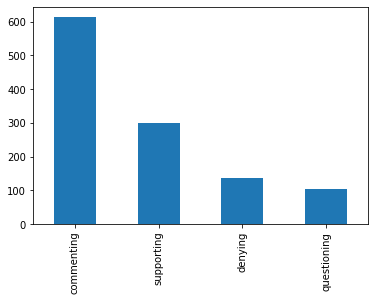

In [224]:
data.labels.value_counts().plot(kind='bar')

In [429]:
# turning into integers
data.loc[data['labels'] == 'supporting', 'labels'] = 0
data.loc[data['labels'] == 'denying', 'labels'] = 1
data.loc[data['labels'] == 'questioning', 'labels'] = 2
data.loc[data['labels'] == 'commenting', 'labels'] = 3
data.head(2)

,labels,body,parent
0,0,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...
1,0,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...


In [430]:
# one-hot encoding
labels = to_categorical(data['labels'], num_classes=4)
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

## Vectorizing with Doc2Vec

In [431]:
import textblob
from textblob import TextBlob

document_1 = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(data['body'])]
#document_1 = [TextBlob(j) for i,j in enumerate(data['body'])]
model_1 = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

W0719 15:07:24.464391  7488 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [432]:
document_2 = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(data['parent'])]
model_2 = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

W0719 15:07:24.620681  7488 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [433]:
model_1.build_vocab(document_1)
model_2.build_vocab(document_2)

In [434]:
vector_1 = []
for i in range(data['body'].shape[0]):
    vector_1.append(list(model_1.infer_vector(data['body'])))

In [435]:
vector_2 = []
for i in range(data['parent'].shape[0]):
    vector_2.append(list(model_1.infer_vector(data['parent'])))

## Modeling with LSTM

In [436]:
df_1 = pd.DataFrame(vector_1)
df_2 = pd.DataFrame(vector_2)
df = df_1.reset_index(drop=True).merge(df_2.reset_index(drop=True), left_index=True, right_index=True)
df.head(2)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0.009025,0.004489,0.00641,0.00854,-0.002019,-0.002739,-0.001982,-0.006572,0.008654,-0.006367,...,-0.000652,-0.001344,-0.008415,0.001648,-0.003093,0.007531,-0.006704,-0.002541,0.000711,-0.004499
1,0.009025,0.004489,0.00641,0.00854,-0.002019,-0.002739,-0.001982,-0.006572,0.008654,-0.006367,...,-0.000652,-0.001344,-0.008415,0.001648,-0.003093,0.007531,-0.006704,-0.002541,0.000711,-0.004499


In [437]:
df.head(2)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0.009025,0.004489,0.00641,0.00854,-0.002019,-0.002739,-0.001982,-0.006572,0.008654,-0.006367,...,-0.000652,-0.001344,-0.008415,0.001648,-0.003093,0.007531,-0.006704,-0.002541,0.000711,-0.004499
1,0.009025,0.004489,0.00641,0.00854,-0.002019,-0.002739,-0.001982,-0.006572,0.008654,-0.006367,...,-0.000652,-0.001344,-0.008415,0.001648,-0.003093,0.007531,-0.006704,-0.002541,0.000711,-0.004499


In [438]:
#df['labels'] = data['labels']

In [439]:
lol = df.values.tolist()
loa = []
for i in lol:
    loa.append(np.asarray(i))
loa = np.array(loa)

In [440]:
X_train, X_test, y_train, y_test = train_test_split(loa, labels, test_size=0.20, random_state=42)

In [441]:
X_train.shape

(924, 100)

In [442]:
X_test.shape

(231, 100)

In [443]:
len(model_1.wv.vocab)

2605

In [444]:
len(model_2.wv.vocab)

3000

In [481]:
# label weights
c = 1.0
s = 20.0
d = 50.0
q = 60.0

In [482]:
epochs = 100
emb_dim = 128
batch_size = 32

model = Sequential()
model.add(Embedding(5605, emb_dim, input_length=df.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,class_weight={0:s,1:d,2:q,3:c},validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 128)          717440    
_________________________________________________________________
spatial_dropout1d_29 (Spatia (None, 100, 128)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 260       
Total params: 767,108
Trainable params: 767,108
Non-trainable params: 0
_________________________________________________________________
None
Train on 739 samples, validate on 185 samples
Epoch 1/100
739/739 [==============================] - 7s 10ms/step - loss: 21.9685 - acc: 0.2030 - val_loss: 20.5380 - val_acc: 0.3027
Epoch 2/100
739/739 [==============================] - 3s 4ms/step - loss: 20.629

In [483]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

231/231 [==============================] - 0s 2ms/step
Test set
  Loss: 2.229
  Accuracy: 0.108


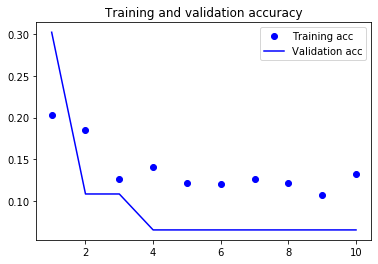

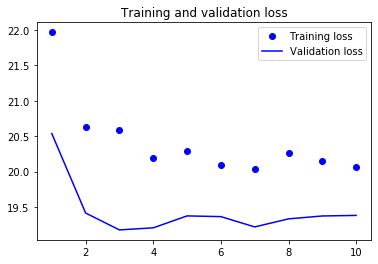

In [484]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [485]:
pred = model.predict(X_test)

In [486]:
ary = []
lb = ['supporting', 'denying', 'questioning', 'commenting']
for i in range(pred.shape[0]):
    ary.append(lb[np.argmax(pred[i])])

In [487]:
sup = [1.,0.,0.,0.]
den = [0.,1.,0.,0.]
que = [0.,0.,1.,0.]
com = [0.,0.,0.,1.]

In [488]:
test = []
for i in range(y_test.shape[0]):
    if( list(y_test[i]) == sup ):
        test.append('supporting')
    elif( list(y_test[i]) == den ):
        test.append('denying')
    elif( list(y_test[i]) == que ):
        test.append('questioning')
    else:
        test.append('commenting')


In [489]:
results = pd.DataFrame(test)
results.columns = ['test']
results['predictions'] = ary

In [490]:
results.head()

,test,predictions
0,commenting,questioning
1,commenting,questioning
2,commenting,questioning
3,denying,questioning
4,denying,questioning


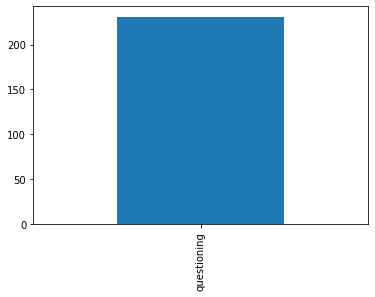

In [491]:
results.predictions.value_counts().plot(kind='bar')